In [13]:
import datetime as dt
from pathlib import Path
import os
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [7]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


## 데이터 전처리

In [8]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
print(f'UserId 고유값 : {data.UserId.nunique()}\nItemId 고유값 : {data.ItemId.nunique()}')

UserId 고유값 : 6040
ItemId 고유값 : 3706


In [5]:
# 평점 정리(3점 이상)
data = data[data['Rating'] >= 3]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [6]:
# 평점 정리(4점 이상)
data = data[data['Rating'] >= 4]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
36,1,1836,5,978300172
...,...,...,...,...
1000119,6040,3671,4,997454367
999923,6040,232,5,997454398
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464


### user length

In [9]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [11]:
long_session = user_length[user_length == 200].index[0]
data[data['UserId'] == long_session]

,UserId,ItemId,Rating,Time
406366,2438,908,3,974222921
406379,2438,2294,3,974222921
406412,2438,3812,5,974222921
406418,2438,3835,2,974222921
406427,2438,1186,4,974222921
...,...,...,...,...
406356,2438,3948,4,979792076
406461,2438,2502,4,981262001
406372,2438,1466,4,981322989
406413,2438,1131,5,987127691


In [12]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

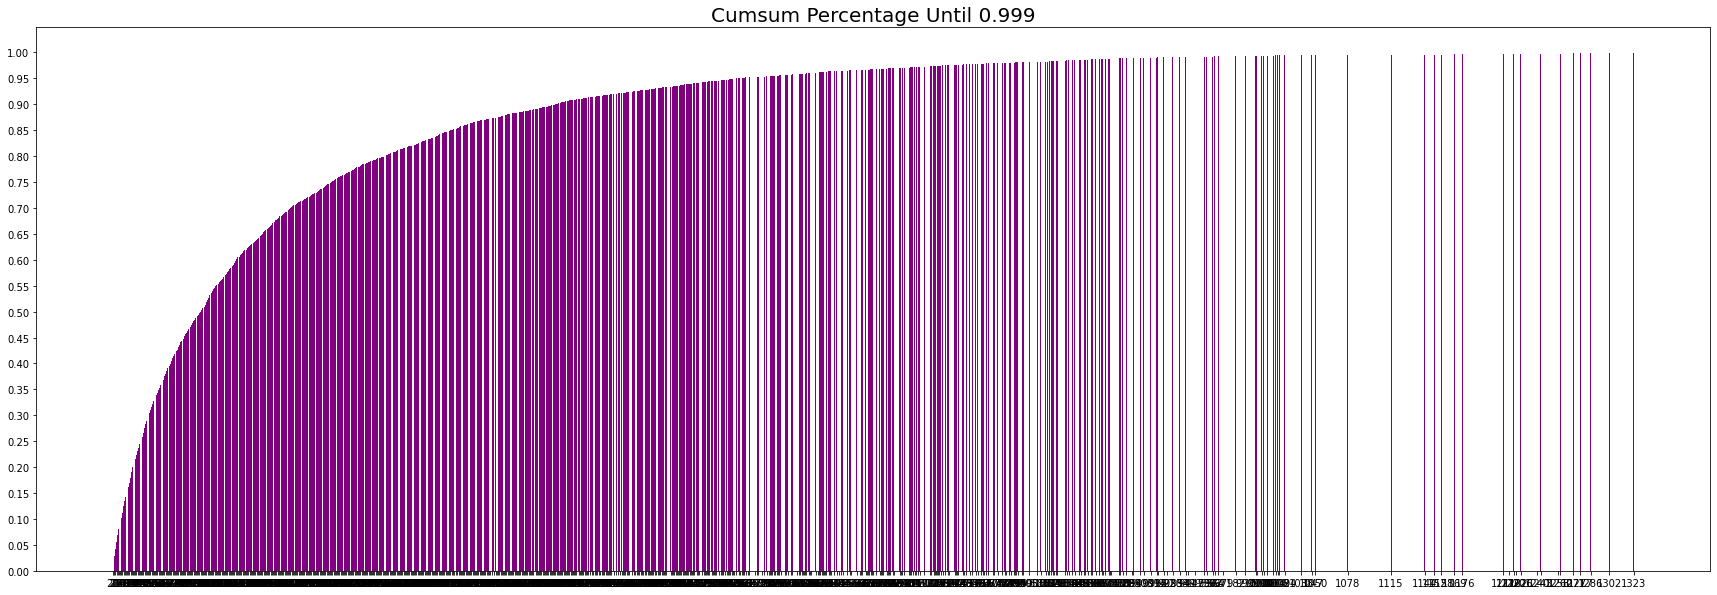

In [20]:
plt.figure(figsize=(30, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='purple')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

In [16]:
data.Time = pd.to_datetime(data.Time, unit ='s')
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


In [17]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(f'oldest : {oldest}\nlatest : {latest}') 

oldest : 2000-04-25 23:05:32
latest : 2003-02-28 17:49:50


### 데이터 정제

In [18]:
def cleanse_recursive(data: pd.DataFrame, least_click, shortest) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_unpopular_item(data, least_click)
        data = cleanse_short_session(data, shortest)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [19]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### Train, Test, Valid set

In [21]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [22]:
tr, test = split_by_date(data, n_days=31)
tr, val = split_by_date(tr, n_days=31)

In [23]:
stats_info(tr, 'train')
stats_info(test, 'test')
stats_info(val, 'valid')

* train Set Stats Info
	 Events: 916670
	 Users: 5849
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-12-27 08:09:30

* test Set Stats Info
	 Events: 52848
	 Users: 107
	 Items: 3175
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50

* valid Set Stats Info
	 Events: 30093
	 Users: 84
	 Items: 2953
	 First Time : 2000-05-10 05:38:09
	 Last Time : 2003-01-28 02:50:23



In [24]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    return df

tr = indexing(tr, id2idx)
test = indexing(test, id2idx)
val = indexing(val, id2idx)

In [25]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
test.to_pickle(save_path / 'test.pkl')
val.to_pickle(save_path / 'valid.pkl')

## 미니 배치 구성

### Session Dataset

In [26]:
class SessionDataset:
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [27]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.tail(10)

,UserId,ItemId,Rating,Time,item_idx
1000169,6040,2725,4,2001-08-10 14:36:20,371
1000105,6040,1673,4,2001-08-10 14:36:52,458
1000118,6040,457,4,2001-08-10 14:39:09,131
1000119,6040,3671,4,2001-08-10 14:39:27,180
999923,6040,232,5,2001-08-10 14:39:58,1097
1000019,6040,2917,4,2001-08-10 14:40:29,1248
999988,6040,1921,4,2001-08-10 14:41:04,370
1000172,6040,1784,3,2001-08-10 14:41:04,89
1000167,6040,161,3,2001-08-10 14:41:26,464
1000042,6040,1221,4,2001-08-20 13:44:15,430


In [28]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 916206, 916329, 916670], dtype=int32)

In [29]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5846, 5847, 5848])

### Session Data Load

In [30]:
class SessionDataLoader:
    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        start, end, mask, last_session, finished = self.initialize()

        while not finished:
            min_len = (end - start).min() - 1
            for i in range(min_len):
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)
        last_session = self.batch_size - 1
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]
        mask = np.array([])
        finished = False
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        
        start += min_len
        mask = np.arange(self.batch_size)[(end - start) == 1]  

        for i, idx in enumerate(mask, start=1):
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:
                finished = True
                break
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)
        return start, end, mask, last_session, finished

In [31]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.tail(15)

,UserId,ItemId,Rating,Time,item_idx
999997,6040,1947,4,2001-08-10 14:33:56,414
1000034,6040,1211,5,2001-08-10 14:34:40,1960
999982,6040,2571,4,2001-08-10 14:35:26,130
1000126,6040,1333,4,2001-08-10 14:35:40,1556
999905,6040,953,5,2001-08-10 14:36:00,586
1000169,6040,2725,4,2001-08-10 14:36:20,371
1000105,6040,1673,4,2001-08-10 14:36:52,458
1000118,6040,457,4,2001-08-10 14:39:09,131
1000119,6040,3671,4,2001-08-10 14:39:27,180
999923,6040,232,5,2001-08-10 14:39:58,1097


In [32]:
iter_ex = iter(tr_data_loader)

In [33]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## 모델 구성

### Evaluation Metric

In [34]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [36]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [37]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [38]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      520200    
_________________________________________________________________
dropout (Dropout)            (32, 50)                  0         
_________________________________________________________________
dense (Dense)                (32, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [39]:
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')
    hidden_states = gru_layer.states[0].numpy()
    for elt in mask:
        hidden_states[elt, :] = 0
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [40]:
train_model(model, args)

Evaluation:  70%|██████▉   | 655/937 [01:41<00:43,  6.44it/s]


	 - Recall@20 epoch 1: 0.231966
	 - MRR@20    epoch 1: 0.060645



Evaluation:  70%|██████▉   | 655/937 [01:38<00:42,  6.63it/s]


	 - Recall@20 epoch 2: 0.259065
	 - MRR@20    epoch 2: 0.072223



Evaluation:  70%|██████▉   | 655/937 [01:35<00:41,  6.83it/s]


	 - Recall@20 epoch 3: 0.268845
	 - MRR@20    epoch 3: 0.076803



Evaluation:  70%|██████▉   | 655/937 [01:35<00:41,  6.87it/s]


	 - Recall@20 epoch 4: 0.270849
	 - MRR@20    epoch 4: 0.079230



Evaluation:  70%|██████▉   | 655/937 [01:35<00:41,  6.86it/s]

	 - Recall@20 epoch 5: 0.273235
	 - MRR@20    epoch 5: 0.080580



## 모델 테스트

In [41]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  78%|███████▊  | 1288/1648 [03:10<00:53,  6.77it/s]

	 - Recall@20: 0.249127
	 - MRR@20: 0.072091



## 마치며
* 모델의 성능이 좋다고 할 수는 없음.
* 에포크를 높여도 MRR 값은 많이 올라가진 않음.
* SBR(Session Based Recommendation)이 잘 되는지는 않다고 볼 수 있음.